### Data Sanity Check

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv(r"C:\Users\nandhana\DS\Course_Projects\Fraud_Transaction\data\Fraud.csv")
df=pd.DataFrame(data)
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


### Importing Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

Feature Engineering

In [4]:
print("Engineering features and handling multicollinearity...")

# Create a copy to avoid modifying the original
df_new = df.copy()

# Transaction type as dummy variables
df_new = pd.get_dummies(df_new, columns=['type'], drop_first=True)

# Engineer features based on balance information
# 1. Balance changes as percentage of transaction amount
df_new['sender_balance_pct_change'] = ((df_new['newbalanceOrig'] - df_new['oldbalanceOrg']) / 
                                      (df_new['amount'] + 1)) * 100  # Add 1 to avoid division by zero

df_new['receiver_balance_pct_change'] = ((df_new['newbalanceDest'] - df_new['oldbalanceDest']) / 
                                        (df_new['amount'] + 1)) * 100


Engineering features and handling multicollinearity...


In [5]:
# 2. Log transformation of amount
df_new['log_amount'] = np.log1p(df_new['amount'])  # log1p to handle zeros

# 3. Zero balance indicators
df_new['orig_zero_balance'] = (df_new['oldbalanceOrg'] == 0).astype(int)
df_new['dest_zero_balance'] = (df_new['oldbalanceDest'] == 0).astype(int)

# 4. Flag cases where money doesn't add up (error detection)
df_new['errorBalanceOrig'] = (abs((df_new['oldbalanceOrg'] - df_new['amount']) - 
                                 df_new['newbalanceOrig']) > 0.01).astype(int)

df_new['errorBalanceDest'] = (abs((df_new['oldbalanceDest'] + df_new['amount']) - 
                                 df_new['newbalanceDest']) > 0.01).astype(int)

# 5. Is recipient a merchant (starting with 'M')
df_new['is_merchant_dest'] = df_new['nameDest'].str.startswith('M').astype(int)

# Drop highly multicollinear original features
columns_to_drop = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 
                   'nameOrig', 'nameDest', 'isFlaggedFraud']
df_engineered = df_new.drop(columns=columns_to_drop)


In [6]:
print("\nChecking VIF after feature engineering:")

# Get numeric columns excluding target
numeric_cols = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
if 'isFraud' in numeric_cols:
    numeric_cols.remove('isFraud')

# Add constant term for statsmodels
X = sm.add_constant(df_engineered[numeric_cols])

# Calculate VIF
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_sorted = vif.sort_values('VIF', ascending=False)
print(vif_sorted)


Checking VIF after feature engineering:


C:\Users\nandhana\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                       Variable         VIF
5                  type_PAYMENT         inf
14             is_merchant_dest         inf
0                         const  137.984060
7     sender_balance_pct_change   20.945457
3                 type_CASH_OUT   20.619176
6                 type_TRANSFER    7.690015
12             errorBalanceOrig    5.181581
11            dest_zero_balance    3.534349
13             errorBalanceDest    2.991246
9                    log_amount    2.963526
10            orig_zero_balance    2.525835
4                    type_DEBIT    1.650114
2                        amount    1.292999
1                          step    1.016381
8   receiver_balance_pct_change    1.000365


In [7]:
print("\nPreparing data for modeling...")

# Split features and target
X = df_engineered.drop('isFraud', axis=1)
y = df_engineered['isFraud']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)



Preparing data for modeling...



Applying SMOTE to handle class imbalance...
Original training set shape: (4771965, 14)
Resampled training set shape: (9531610, 14)
Original class distribution: 0    0.998709
1    0.001291
Name: isFraud, dtype: float64
Resampled class distribution: 0    0.5
1    0.5
Name: isFraud, dtype: float64


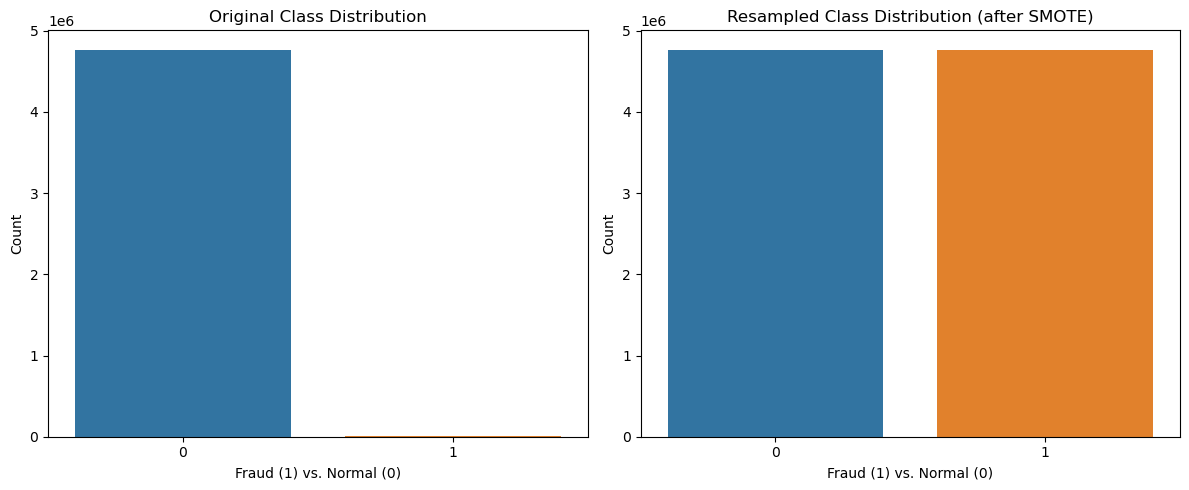

In [8]:
print("\nApplying SMOTE to handle class imbalance...")

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution before and after SMOTE
print(f"Original training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Original class distribution: {pd.Series(y_train).value_counts(normalize=True)}")
print(f"Resampled class distribution: {pd.Series(y_train_resampled).value_counts(normalize=True)}")

# Visualize class distribution before and after SMOTE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Original Class Distribution')
plt.xlabel('Fraud (1) vs. Normal (0)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Resampled Class Distribution (after SMOTE)')
plt.xlabel('Fraud (1) vs. Normal (0)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Modelling - RF

In [9]:
print("\nTraining Random Forest...")

# Initialize and train Random Forest model
rf = RandomForestClassifier(random_state=42, 
                           n_estimators=100,
                           max_depth=10,
                           min_samples_split=10,
                           class_weight='balanced')



Training Random Forest...


In [10]:
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=10, random_state=42)

In [14]:
# Get predictions
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99   1588602
           1       0.05      0.96      0.09      2053

    accuracy                           0.97   1590655
   macro avg       0.52      0.97      0.54   1590655
weighted avg       1.00      0.97      0.99   1590655

ROC AUC Score: 0.9967


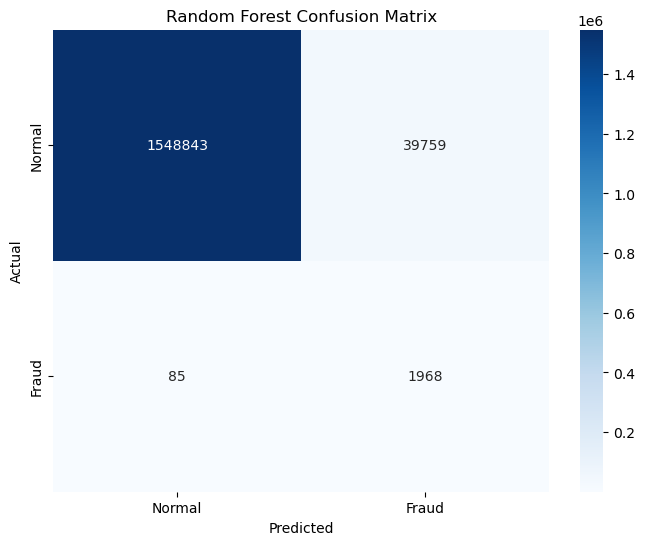

In [15]:
# Evaluate Random Forest
print("\nRandom Forest Classification Report:")
rf_report = classification_report(y_test, y_pred_rf)
print(rf_report)
rf_auc = roc_auc_score(y_test, y_prob_rf)
print(f"ROC AUC Score: {rf_auc:.4f}")

# Random Forest confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues',
           xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


Top 10 Features by Importance:
                        Feature  Importance
6     sender_balance_pct_change    0.327512
11             errorBalanceOrig    0.309205
1                        amount    0.060122
4                  type_PAYMENT    0.059212
13             is_merchant_dest    0.058545
8                    log_amount    0.046420
7   receiver_balance_pct_change    0.036254
9             orig_zero_balance    0.027047
0                          step    0.024448
5                 type_TRANSFER    0.014787


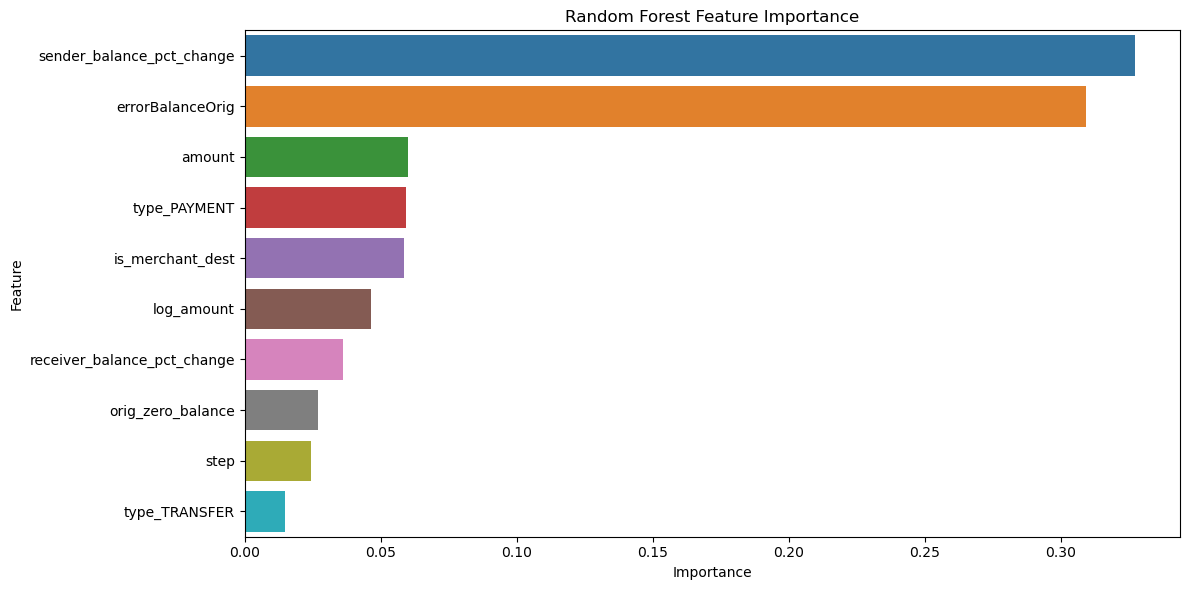

In [16]:
# Feature importance
feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features by Importance:")
print(feature_imp.head(10))

# Plot top 10 features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10))
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

Random Forest Model Insights

Top Features:

    - sender_balance_pct_change (0.327512) is the most important predictor
    - errorBalanceOrig (0.309205) is a close second
    - amount (0.060122) ranks third but with significantly lower importance


Feature Distribution:

    The importance scores show a two-tier structure:

    - Two dominant features (both above 0.3)
    - Eight secondary features (all below 0.07)


More gradual decrease in importance across features compared to XGBoost


Feature Categories:

    - Balance-related features are critical (sender_balance_pct_change, receiver_balance_pct_change, orig_zero_balance)
    - Error indicators appear significant (errorBalanceOrig)
    - Transaction attributes (amount, log_amount, type_PAYMENT, type_TRANSFER) show moderate importance
    - Merchant indicators (is_merchant_dest) are moderately important


Notable Pattern:

    - Both relative values (percentage changes) and absolute values (amount, log_amount) contribute to the model
    The step feature shows some relevance at 0.024448

### Modelling - LR

In [17]:
# Logistic Regression Model
print("\nTraining Logistic Regression...")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt




Training Logistic Regression...


In [18]:
# Initialize and train Logistic Regression model
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]




Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1588602
           1       0.03      0.96      0.06      2053

    accuracy                           0.96   1590655
   macro avg       0.51      0.96      0.52   1590655
weighted avg       1.00      0.96      0.98   1590655

ROC AUC Score: 0.9867


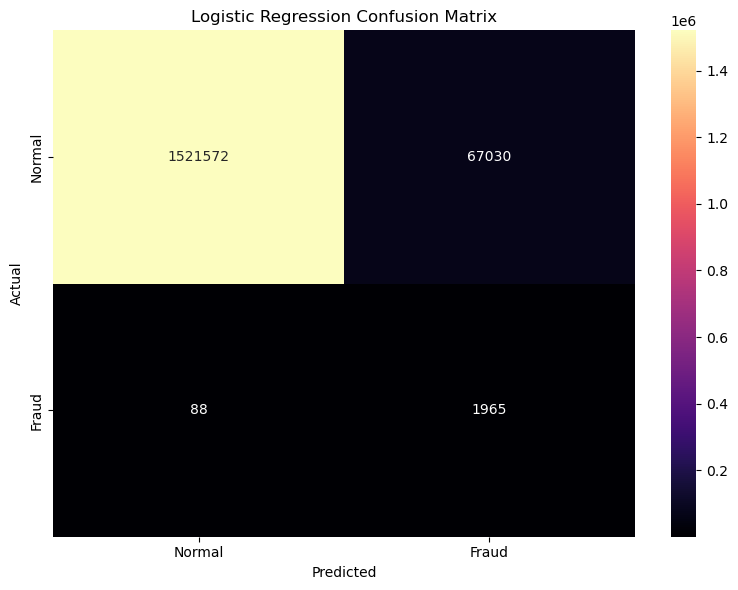

In [19]:
# Evaluate Logistic Regression
print("\nLogistic Regression Classification Report:")
lr_report = classification_report(y_test, y_pred_lr)
print(lr_report)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_lr):.4f}")

# Logistic Regression Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d',  cmap='magma',
            xticklabels=['Normal', 'Fraud'], 
            yticklabels=['Normal', 'Fraud'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()



### Modelling - XGB

In [20]:
# XGBoost Model
print("\nTraining XGBoost...")
import xgboost as xgb
from xgboost import XGBClassifier



Training XGBoost...


In [21]:

# Initialize and train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    random_state=42, 
    scale_pos_weight=1,  # Important for imbalanced datasets
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_resampled, y_train_resampled)



C:\Users\nandhana\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:13:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [22]:
# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate XGBoost
print("\nXGBoost Classification Report:")
xgb_report = classification_report(y_test, y_pred_xgb)
print(xgb_report)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_xgb):.4f}")



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1588602
           1       0.06      0.95      0.12      2053

    accuracy                           0.98   1590655
   macro avg       0.53      0.97      0.55   1590655
weighted avg       1.00      0.98      0.99   1590655

ROC AUC Score: 0.9971


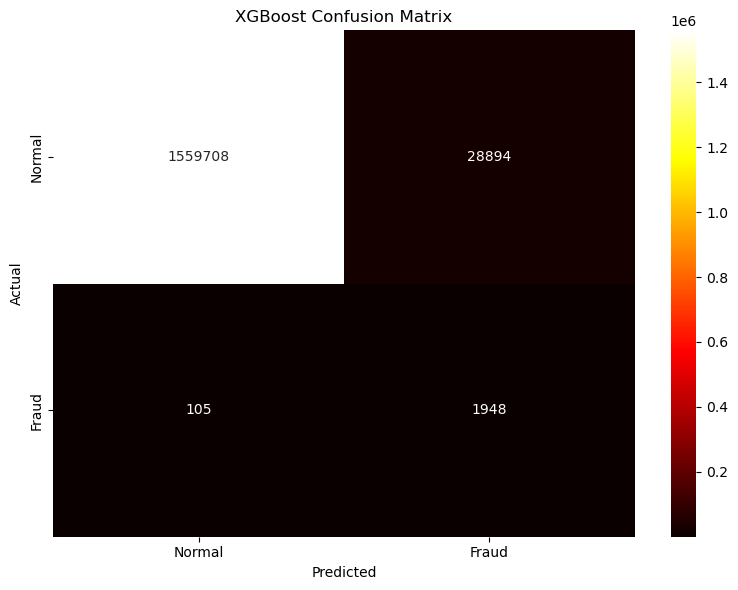

In [23]:

# XGBoost Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d',  cmap='hot',
            xticklabels=['Normal', 'Fraud'], 
            yticklabels=['Normal', 'Fraud'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

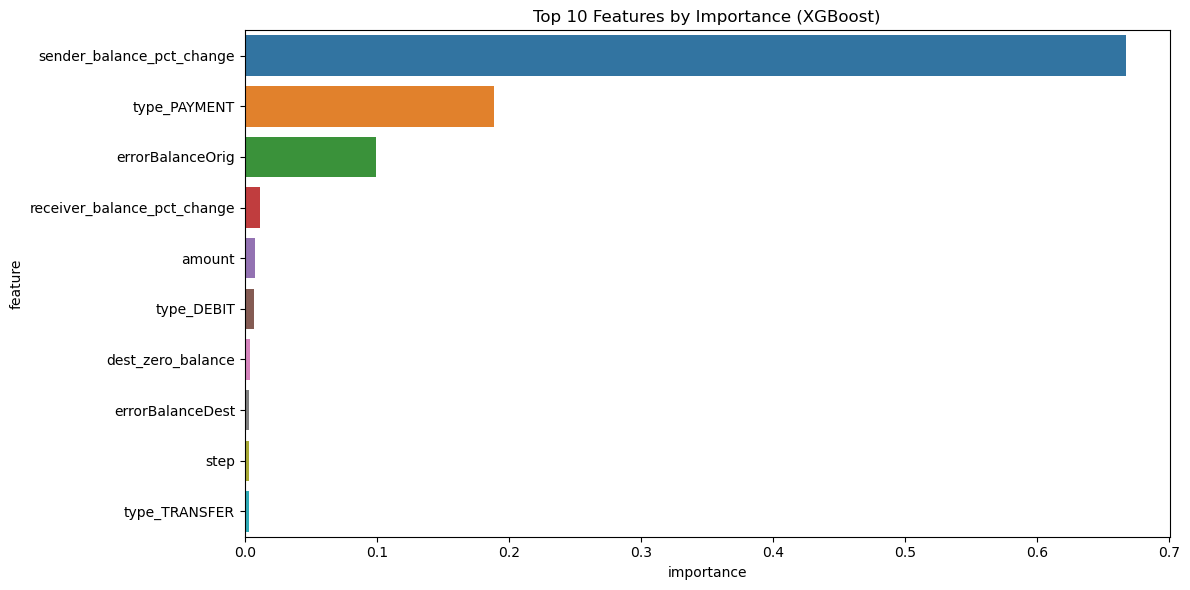

In [24]:

# Feature Importance for XGBoost
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_imp.head(10))
plt.title('Top 10 Features by Importance (XGBoost)')
plt.tight_layout()
plt.show()

XGBoost Model Insights

Top Features:

    - sender_balance_pct_change dominates with much higher importance (approximately 0.67)
    - type_PAYMENT (approximately 0.18) is the distant second
    - errorBalanceOrig (approximately 0.12) is in third position


Feature Distribution:

    - Extremely steep drop-off after the top feature
    - Top feature has nearly 4x the importance of the second feature
    - Many features have near-zero importance


Feature Categories:

    - Balance changes overwhelmingly drive predictions
    - Transaction types (type_PAYMENT) are secondary indicators
    - Error states contribute but less prominently than in Random Forest
    - Most other features have minimal impact on the model's decisions


Notable Pattern:

    - XGBoost is much more selective/focused on fewer features
    - The model heavily relies on sender_balance_pct_change as the primary signal
    - Several features that had moderate importance in Random Forest (amount, is_merchant_dest, log_amount) have minimal impact in XGBoost

### Explainability

In [25]:
import lime
import lime.lime_tabular

##Create an explainer
predict_fn_rf = lambda x: rf.predict_proba(x).astype(float)
X = X_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = X_train.columns,class_names=['Fraud','Not Fraud'],kernel_width=5)

In [26]:
row_display = X_test.loc[410]
display(row_display) 

step                               1.000000
amount                         73199.100000
type_CASH_OUT                      0.000000
type_DEBIT                         0.000000
type_PAYMENT                       0.000000
type_TRANSFER                      0.000000
sender_balance_pct_change         99.998620
receiver_balance_pct_change     -169.960424
log_amount                        11.200952
orig_zero_balance                  0.000000
dest_zero_balance                  0.000000
errorBalanceOrig                   1.000000
errorBalanceDest                   1.000000
is_merchant_dest                   0.000000
Name: 410, dtype: float64

In [27]:
random_indices = np.random.choice(X_test.index, size=10, replace=False)  # Select 10 unique random indices
print("Random indices in X_test:", random_indices)

Random indices in X_test: [ 246970  332440 3291455 4586185 2879195  496257 2477954 5385849 3844112
 4348034]


In [28]:
chosen_instance = X_test.loc[[3794107]].values[0]
exp = explainer.explain_instance(chosen_instance, predict_fn_rf, num_features=10)
exp.show_in_notebook(show_all=False)

C:\Users\nandhana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [29]:
choosen_instance = X_test.loc[[3963907]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

C:\Users\nandhana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Pickling

In [33]:
import os
import pickle

# Create the models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save models
with open('models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

with open('models/lr_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

with open('models/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)